In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
# Loading the dataset
nvda_data = pd.read_csv('NVDA.csv')

nvda_data.head()

,Date,Adj Close,Close,High,Low,Open,Volume
0,28/11/2022,15.812541,15.827000,16.357000,15.725,16.025999,303741000
1,29/11/2022,15.624713,15.639000,15.932000,15.520,15.827000,298384000
2,30/11/2022,16.911863,16.923000,16.930000,15.597,15.697000,565298000
3,01/12/2022,17.123726,17.135000,17.264999,16.635,16.999001,470977000
4,02/12/2022,16.864895,16.875999,16.933001,16.445,16.659000,371389000


In [3]:
# Create the 'Trend' column based on the next day's 'Adj Close'
threshold = 0.001  # ±0.1% range for "Stable"
nvda_data['Trend'] = np.where(nvda_data['Adj Close'].shift(-1) > nvda_data['Adj Close'], 'Up',
                              np.where(nvda_data['Adj Close'].shift(-1) < nvda_data['Adj Close'], 'Down', 'Stable'))

# Drop the last row (no next-day data for the target)
nvda_data = nvda_data[:-1]
print(nvda_data[['Date', 'Adj Close', 'Trend']].tail())


           Date   Adj Close Trend
497  19/11/2024  147.009995  Down
498  20/11/2024  145.889999    Up
499  21/11/2024  146.669998  Down
500  22/11/2024  141.949997  Down
501  25/11/2024  136.020004    Up


In [4]:
# Add daily percentage change as a feature
nvda_data['Pct Change'] = (nvda_data['Close'] - nvda_data['Open']) / nvda_data['Open']

features = ['Close', 'High', 'Low', 'Open', 'Volume', 'Pct Change']
X = nvda_data[features]
y = nvda_data['Trend']

# Display sample features and target
print(X.head())
print(y.head())


       Close       High     Low       Open     Volume  Pct Change
0  15.827000  16.357000  15.725  16.025999  303741000   -0.012417
1  15.639000  15.932000  15.520  15.827000  298384000   -0.011878
2  16.923000  16.930000  15.597  15.697000  565298000    0.078104
3  17.135000  17.264999  16.635  16.999001  470977000    0.008000
4  16.875999  16.933001  16.445  16.659000  371389000    0.013026
0    Down
1      Up
2      Up
3    Down
4    Down
Name: Trend, dtype: object


In [5]:
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [6]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Display the sizes of the datasets
print(f"Training set size: {len(X_train)}, Test set size: {len(X_test)}")


Training set size: 401, Test set size: 101


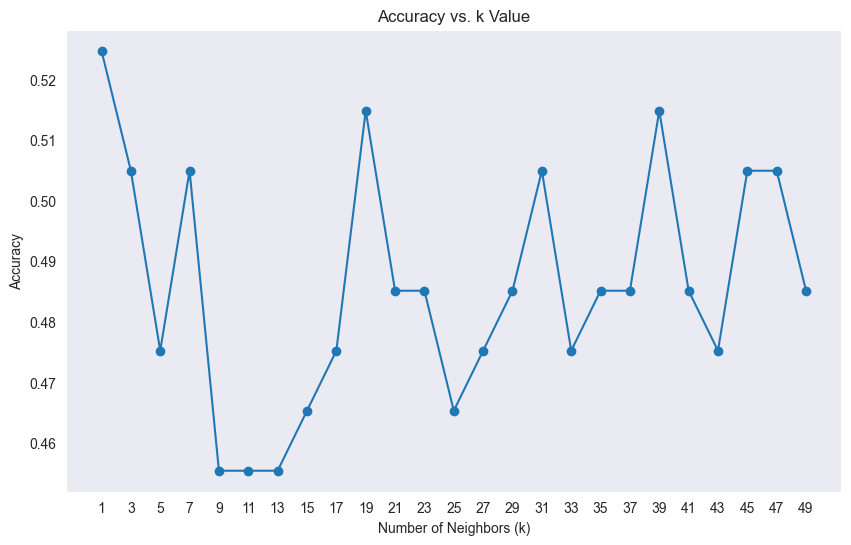

The best k value is: 1 with accuracy: 0.52


In [7]:
# Test multiple values of k
k_values = range(1, 51,2)
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

# Plot the accuracy for each k value
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o')
plt.title("Accuracy vs. k Value")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.xticks(k_values)
plt.grid()
plt.show()

# Find the best k
best_k = k_values[np.argmax(accuracies)]
print(f"The best k value is: {best_k} with accuracy: {max(accuracies):.2f}")



In [8]:
# Train the kNN classifier with the best k value
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)

# Make predictions
y_pred = knn.predict(X_test)


In [9]:
# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)


Classification Report:
               precision    recall  f1-score   support

        Down       0.49      0.43      0.46        46
      Stable       0.00      0.00      0.00         1
          Up       0.55      0.61      0.58        54

    accuracy                           0.52       101
   macro avg       0.35      0.35      0.35       101
weighted avg       0.52      0.52      0.52       101

Confusion Matrix:
 [[20  0 26]
 [ 0  0  1]
 [21  0 33]]


C:\Users\R\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\R\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\R\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

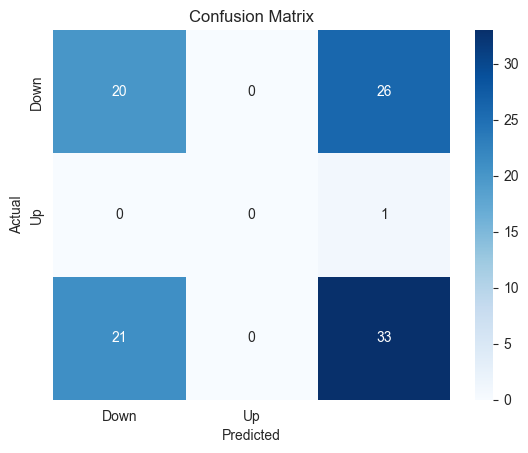

In [10]:
# Visualize confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=knn.classes_, yticklabels=knn.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [11]:
# Calculate the accuracy
accuracy = knn.score(X_test, y_test)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.52
